# iModulon PCA

PCA visualizations for E. coli and P. putida using A and X matrices.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib import colors as mcolors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
from pathlib import Path

font_path = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf"
font_manager.fontManager.addfont(font_path)
font_prop = font_manager.FontProperties(fname=font_path)

colors = {
    '1000:1': '#9367ac',
    '1:1': '#f2b340',
    '1:1000': '#94c47d',
    'mono': '#6f8ec9',
}

def load_data():
    data_dir = Path('A_Matrices')
    x_dir = Path('X_Matrices')
    ecoli_A = pd.read_csv(data_dir / 'E_coli_A.csv', index_col=0)
    pputida_A = pd.read_csv(data_dir / 'P_putida_A.csv', index_col=0)
    ecoli_X = pd.read_csv(x_dir / 'X_E_coli.csv', index_col=0)
    pputida_X = pd.read_csv(x_dir / 'X_P_putida.csv', index_col=0)
    return ecoli_A, pputida_A, ecoli_X, pputida_X

def extract_labels_and_times(columns, organism):
    labels = []
    times = []
    for c in columns:
        parts = c.split('_')
        if c.startswith('1000:1'):
            labels.append('1000:1'); times.append(parts[1] if len(parts) > 1 else '')
        elif c.startswith('1:1000'):
            labels.append('1:1000'); times.append(parts[1] if len(parts) > 1 else '')
        elif c.startswith('1:1'):
            labels.append('1:1'); times.append(parts[1] if len(parts) > 1 else '')
        elif c.startswith('E_coli_') and organism == 'E_coli':
            # format E_coli_<time>_<rep>
            times.append(parts[2] if len(parts) > 2 else '')
            labels.append('mono')
        elif c.startswith('P_putida_') and organism == 'P_putida':
            # format P_putida_<time>_<rep>
            times.append(parts[2] if len(parts) > 2 else '')
            labels.append('mono')
        else:
            labels.append('other'); times.append(parts[1] if len(parts) > 1 else '')
    return labels, times

def run_pca(matrix, n=2, scale=False):
    X = matrix.T
    if scale:
        X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=n)
    scores = pca.fit_transform(X)
    loadings = pca.components_.T
    return pca, scores, loadings

def plot_scores(scores, labels, times, pca, organism, title_prefix, fig_size=(7,5), save_path=None):
    scores = np.array(scores)
    fig, ax = plt.subplots(figsize=fig_size)
    sections = ['1000:1','1:1','1:1000','mono']
    texts = []
    x_span = np.ptp(scores[:,0]) if scores.shape[0] > 0 else 1
    y_span = np.ptp(scores[:,1]) if scores.shape[0] > 0 else 1
    dx = 0.02 * x_span
    dy = 0.02 * y_span
    for sec in sections:
        mask = [l==sec for l in labels]
        if any(mask):
            pts = scores[mask]
            ax.scatter(pts[:,0], pts[:,1], color=colors[sec], edgecolor='black', s=50, label=sec)
            sel_times = np.array(times)[mask]
            for (x, y), t in zip(pts, sel_times):
                texts.append(ax.text(x + dx, y + dy, t, fontproperties=font_prop, fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)", fontproperties=font_prop)
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)", fontproperties=font_prop)
    ax.set_title(f"PCA - {organism} {title_prefix}", fontproperties=font_prop)
    for tick in ax.get_xticklabels()+ax.get_yticklabels():
        tick.set_fontproperties(font_prop)
    ax.legend()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    return fig, ax

def plot_biplot(scores, loadings, labels, times, feature_names, pca,
                organism, title_prefix, fig_size=(7,5),
                save_path=None, top_n=5, scale_loadings=3.0):

    scores = np.array(scores)
    loadings = np.array(loadings)

    fig, ax = plt.subplots(figsize=fig_size)

    sections = ['1000:1', '1:1', '1:1000', 'mono']
    texts_pts = []

    x_span = np.ptp(scores[:, 0]) if scores.shape[0] > 0 else 1
    y_span = np.ptp(scores[:, 1]) if scores.shape[0] > 0 else 1
    dx = 0.01 * x_span
    dy = 0.01 * y_span

    for sec in sections:
        mask = [l == sec for l in labels]
        if any(mask):
            pts = scores[mask]
            ax.scatter(
                pts[:, 0], pts[:, 1],
                color=colors[sec],
                edgecolor='black',
                s=50,
                label=sec
            )
            sel_times = np.array(times)[mask]
            for (x, y), t in zip(pts, sel_times):
                texts_pts.append(
                    ax.text(x + dx, y + dy, t,
                            fontproperties=font_prop,
                            fontsize=8)
                )

    adjust_text(
        texts_pts,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        ax=ax
    )

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.axvline(0, color='grey', linewidth=0.8)

    magnitudes = np.sqrt(loadings[:, 0]**2 + loadings[:, 1]**2)
    top_idx = np.argsort(magnitudes)[-top_n:]

    ax.quiver(
        np.zeros(len(top_idx)),
        np.zeros(len(top_idx)),
        loadings[top_idx, 0] * scale_loadings,
        loadings[top_idx, 1] * scale_loadings,
        angles='xy',
        scale_units='xy',
        scale=1,
        color='black',
        width=0.003,
        alpha=0.6
    )

    text_objs = []
    for i in top_idx:
        text_objs.append(
            ax.text(
                loadings[i, 0] * scale_loadings * 1.2,
                loadings[i, 1] * scale_loadings * 1.2,
                feature_names[i],
                fontsize=8,
                fontproperties=font_prop
            )
        )

    adjust_text(
        text_objs,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        ax=ax
    )

    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100

    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)", fontproperties=font_prop)
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)", fontproperties=font_prop)
    ax.set_title(
        f"PCA biplot - {organism} {title_prefix}",
        fontproperties=font_prop
    )

    for tick in ax.get_xticklabels() + ax.get_yticklabels():
        tick.set_fontproperties(font_prop)

    # --- legend font fix ---
    legend = ax.legend()
    for text in legend.get_texts():
        text.set_fontproperties(font_prop)
    # ----------------------

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

    return fig, ax



TIME_ORDER = ['0h','4h','8h','24h']
TIME_FACTORS = [0.55, 0.7, 0.85, 1.0]


def blend_with_white(hex_color, factor):
    rgb = np.array(mcolors.to_rgb(hex_color))
    return tuple(rgb * factor + (1 - factor) * 1.0)


def section_time_colors(labels, times):
    time_factor = {t: f for t, f in zip(TIME_ORDER, TIME_FACTORS)}
    out_colors = []
    legend_map = {}
    for lab, t in zip(labels, times):
        base = colors.get(lab, '#777777')
        f = time_factor.get(t, 0.75)
        out_colors.append(blend_with_white(base, f))
    base_for_legend = colors['1000:1']
    for t, f in zip(TIME_ORDER, TIME_FACTORS):
        legend_map[t] = blend_with_white(base_for_legend, f)
    return out_colors, legend_map


def plot_scores_timecolor(scores, labels, times, pca, organism, title_prefix, fig_size=(7,5), save_path=None):
    scores = np.array(scores)
    fig, ax = plt.subplots(figsize=fig_size)
    time_colors, legend_map = section_time_colors(labels, times)
    sections = ['1000:1','1:1','1:1000','mono']
    texts = []
    x_span = np.ptp(scores[:,0]) if scores.shape[0] > 0 else 1
    y_span = np.ptp(scores[:,1]) if scores.shape[0] > 0 else 1
    dx = 0.02 * x_span
    dy = 0.02 * y_span
    time_array = np.array(times)
    color_array = np.array(time_colors)
    for sec in sections:
        mask = np.array([l==sec for l in labels])
        if mask.any():
            pts = scores[mask]
            sel_times = time_array[mask]
            sel_colors = color_array[mask]
            ax.scatter(pts[:,0], pts[:,1], c=list(sel_colors), edgecolor='black', s=50, label=f"{sec}")
            for (x, y), t in zip(pts, sel_times):
                texts.append(ax.text(x + dx, y + dy, t, fontproperties=font_prop, fontsize=8))
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), ax=ax)
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)", fontproperties=font_prop)
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)", fontproperties=font_prop)
    ax.set_title(f"{title_prefix} PCA scores (time gradient, {organism})", fontproperties=font_prop)
    for tick in ax.get_xticklabels()+ax.get_yticklabels():
        tick.set_fontproperties(font_prop)
    from matplotlib.patches import Patch
    time_patches = [Patch(facecolor=legend_map[t], edgecolor='black', label=t) for t in TIME_ORDER]
    section_patches = [Patch(facecolor=colors[s], edgecolor='black', label=s) for s in sections]
    
    # legend1 = ax.legend(handles=section_patches, title='Starting ratio', loc='upper right')
    # ax.add_artist(legend1)
    # ax.legend(handles=time_patches, title='Time', loc='lower right')


    legend1 = ax.legend(
    handles=section_patches,
    title='Starting ratio',
    loc='upper right',
    prop=font_prop,
    title_fontproperties=font_prop
    )
    ax.add_artist(legend1)
    

    ax.legend(
        handles=time_patches,
        title='Time',
        loc='lower right',
        prop=font_prop,
        title_fontproperties=font_prop
    )
    for legend in [legend1]:
        for text in legend.get_texts():
            text.set_fontproperties(font_prop)
        legend.get_title().set_fontproperties(font_prop)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    return fig, ax


In [54]:
Ecoli_A, Pputida_A, Ecoli_X, Pputida_X = load_data()
print('Loaded A/X matrices')


Loaded A/X matrices


In [70]:
colors = {
    '1000:1': '#F6FAF2',
    '1:1': '#C4E0B8',
    '1:1000': '#E9EDAD',
    'mono': '#61A15D',
}

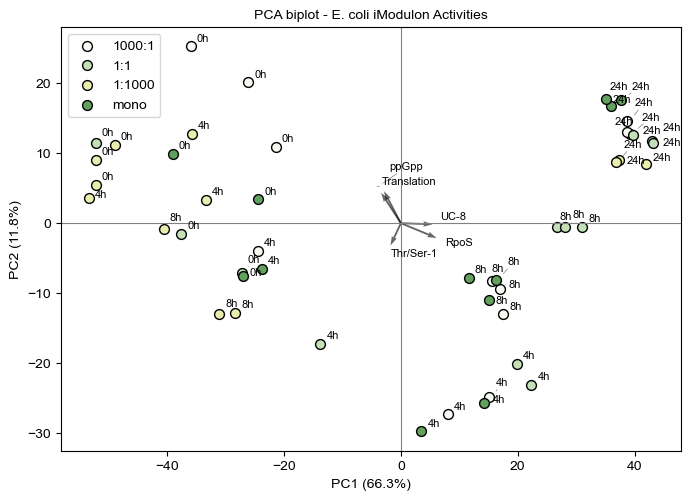

In [71]:
labels_ec_A, times_ec_A = extract_labels_and_times(Ecoli_A.columns, 'E_coli')
pca_ec_A, scores_ec_A, loadings_ec_A = run_pca(Ecoli_A)
fig, ax = plot_biplot(scores_ec_A, loadings_ec_A, labels_ec_A, times_ec_A, Ecoli_A.index.tolist(), pca_ec_A, 'E. coli', 'iModulon Activities', fig_size=(8,5.5), save_path="PCA_biplot_E_coli.svg", top_n=5, scale_loadings=15)
plt.show()


In [64]:
colors = {
    '1000:1': '#F2F7FA',
    '1:1': '#B8D3E0',
    '1:1000': '#D5C4E0',
    'mono': '#4989BD',
}

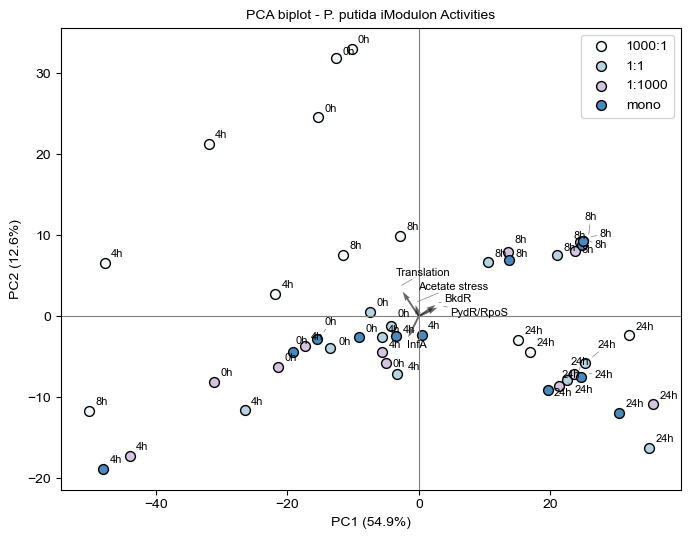

In [68]:
labels_pp_A, times_pp_A = extract_labels_and_times(Pputida_A.columns, 'P_putida')
pca_pp_A, scores_pp_A, loadings_pp_A = run_pca(Pputida_A)
fig, ax = plot_biplot(scores_pp_A, loadings_pp_A, labels_pp_A, times_pp_A, Pputida_A.index.tolist(), pca_pp_A, 'P. putida', 'iModulon Activities', fig_size=(8,6), save_path="PCA_biplot_P_putida.svg", top_n=5, scale_loadings=6)
plt.show()
